In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import os

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
seed_everything()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
basic_transform = transforms.ToTensor()

augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
unlabeled_dataset = STL10(root="./data", split='unlabeled', download=True, transform=transforms.ToTensor())
train_dataset = STL10(root="./data", split='train', download=True, transform=transforms.ToTensor())
test_dataset = STL10(root="./data", split='test', download=True, transform=transforms.ToTensor())

100%|██████████| 2.64G/2.64G [02:44<00:00, 16.1MB/s]


In [6]:
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=256, shuffle=True, num_workers=4)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
def get_resnet_encoder():
    model = resnet18(pretrained=False)
    model.fc = nn.Identity()
    return model

In [8]:
class SimCLR(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        reps = self.encoder(x)
        z = self.projector(reps)
        return z

In [9]:
def simclr_loss(z1, z2, temperature=0.5):
    z1 = nn.functional.normalize(z1, dim=1)
    z2 = nn.functional.normalize(z2, dim=1)

    batch_size = z1.size(0)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T)


    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(device)
    similarity_matrix = similarity_matrix / temperature
    similarity_matrix.masked_fill_(mask, -1e9)

    positives = torch.exp(torch.sum(z1 * z2, dim=-1) / temperature)
    negatives = torch.exp(similarity_matrix).sum(dim=-1)

    loss = -torch.log(positives / (negatives[:batch_size] + negatives[batch_size:]))
    return loss.mean()

In [10]:
def train_simclr(dataloader, epochs=10):
    encoder = get_resnet_encoder().to(device)
    model = SimCLR(encoder).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _ in tqdm(dataloader):
            x1 = torch.stack([augmentation_transform(transforms.ToPILImage()(img)) for img in x])
            x2 = torch.stack([augmentation_transform(transforms.ToPILImage()(img)) for img in x])
            x1, x2 = x1.to(device), x2.to(device)

            z1 = model(x1)
            z2 = model(x2)

            loss = simclr_loss(z1, z2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[SimCLR] Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

    return encoder

In [11]:
class BYOL(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.online_encoder = encoder
        self.target_encoder = get_resnet_encoder().to(device)
        self.predictor = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )
        self.target_encoder.load_state_dict(self.online_encoder.state_dict())
        for param in self.target_encoder.parameters():
            param.requires_grad = False

    def forward(self, x1, x2):
        online_proj1 = self.predictor(self.online_encoder(x1))
        online_proj2 = self.predictor(self.online_encoder(x2))
        with torch.no_grad():
            target_proj1 = self.target_encoder(x1)
            target_proj2 = self.target_encoder(x2)
        return online_proj1, online_proj2, target_proj1.detach(), target_proj2.detach()

In [12]:
def train_byol(dataloader, epochs=10):
    encoder = get_resnet_encoder().to(device)
    model = BYOL(encoder).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _ in tqdm(dataloader):
            x1 = torch.stack([augmentation_transform(transforms.ToPILImage()(img)) for img in x])
            x2 = torch.stack([augmentation_transform(transforms.ToPILImage()(img)) for img in x])
            x1, x2 = x1.to(device), x2.to(device)

            online_proj1, online_proj2, target_proj1, target_proj2 = model(x1, x2)

            loss = criterion(online_proj1, target_proj2) + criterion(online_proj2, target_proj1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[BYOL] Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

    return model.online_encoder

In [13]:
class BarlowTwins(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.projector = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

    def forward(self, x):
        return self.projector(self.encoder(x))


In [14]:
def train_barlow(dataloader, epochs=10, lambd=5e-3):
    encoder = get_resnet_encoder().to(device)
    model = BarlowTwins(encoder).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _ in tqdm(dataloader):
            x1 = torch.stack([augmentation_transform(transforms.ToPILImage()(img)) for img in x])
            x2 = torch.stack([augmentation_transform(transforms.ToPILImage()(img)) for img in x])
            x1, x2 = x1.to(device), x2.to(device)

            z1 = model(x1)
            z2 = model(x2)

            z1_norm = (z1 - z1.mean(0)) / z1.std(0)
            z2_norm = (z2 - z2.mean(0)) / z2.std(0)

            c = torch.mm(z1_norm.T, z2_norm) / z1.size(0)

            on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
            off_diag = (c - torch.eye(c.size(0), device=c.device)).pow_(2).sum() - on_diag
            loss = on_diag + lambd * off_diag

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"[Barlow] Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

    return encoder


In [15]:
def extract_features(encoder, dataloader):
    encoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in tqdm(dataloader):
            x = x.to(device)
            reps = encoder(x).cpu().numpy()
            features.append(reps)
            labels.append(y.numpy())
    return np.vstack(features), np.concatenate(labels)

In [16]:
def linear_probe(train_features, train_labels, test_features, test_labels):
    clf = LogisticRegression(max_iter=5000)
    clf.fit(train_features, train_labels)
    preds = clf.predict(test_features)
    acc = accuracy_score(test_labels, preds)
    return acc

In [17]:
def plot_results(results):
    names = list(results.keys())
    scores = list(results.values())
    plt.bar(names, scores, color='skyblue')
    plt.ylabel('Accuracy')
    plt.title('Сравнение качества эмбеддингов')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()


In [18]:
if __name__ == "__main__":
    simclr_encoder = train_simclr(unlabeled_loader, epochs=10)
    byol_encoder = train_byol(unlabeled_loader, epochs=10)
    barlow_encoder = train_barlow(unlabeled_loader, epochs=10)

    print("\n[SimCLR] Извлечение признаков...")
    simclr_features_train, simclr_labels_train = extract_features(simclr_encoder, train_loader)
    simclr_features_test, simclr_labels_test = extract_features(simclr_encoder, test_loader)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 391/391 [06:07<00:00,  1.06it/s]


[SimCLR] Epoch 1, Loss: 5.4455


100%|██████████| 391/391 [05:59<00:00,  1.09it/s]


[SimCLR] Epoch 2, Loss: 5.3093


100%|██████████| 391/391 [06:09<00:00,  1.06it/s]


[SimCLR] Epoch 3, Loss: 5.2706


100%|██████████| 391/391 [06:10<00:00,  1.06it/s]


[SimCLR] Epoch 4, Loss: 5.2540


100%|██████████| 391/391 [06:07<00:00,  1.06it/s]


[SimCLR] Epoch 5, Loss: 5.2395


100%|██████████| 391/391 [06:12<00:00,  1.05it/s]


[SimCLR] Epoch 6, Loss: 5.2288


100%|██████████| 391/391 [06:13<00:00,  1.05it/s]


[SimCLR] Epoch 7, Loss: 5.2185


100%|██████████| 391/391 [06:12<00:00,  1.05it/s]


[SimCLR] Epoch 8, Loss: 5.2117


100%|██████████| 391/391 [06:13<00:00,  1.05it/s]


[SimCLR] Epoch 9, Loss: 5.2065


100%|██████████| 391/391 [06:16<00:00,  1.04it/s]


[SimCLR] Epoch 10, Loss: 5.1998


100%|██████████| 391/391 [06:45<00:00,  1.04s/it]


[BYOL] Epoch 1, Loss: 0.2542


100%|██████████| 391/391 [06:40<00:00,  1.02s/it]


[BYOL] Epoch 2, Loss: 0.2298


100%|██████████| 391/391 [06:44<00:00,  1.04s/it]


[BYOL] Epoch 3, Loss: 0.2263


100%|██████████| 391/391 [06:37<00:00,  1.02s/it]


[BYOL] Epoch 4, Loss: 0.2252


100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


[BYOL] Epoch 5, Loss: 0.2245


100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


[BYOL] Epoch 6, Loss: 0.2229


100%|██████████| 391/391 [06:40<00:00,  1.02s/it]


[BYOL] Epoch 7, Loss: 0.2227


100%|██████████| 391/391 [06:39<00:00,  1.02s/it]


[BYOL] Epoch 8, Loss: 0.2222


100%|██████████| 391/391 [06:38<00:00,  1.02s/it]


[BYOL] Epoch 9, Loss: 0.2219


100%|██████████| 391/391 [06:40<00:00,  1.02s/it]


[BYOL] Epoch 10, Loss: 0.2217


100%|██████████| 391/391 [06:08<00:00,  1.06it/s]


[Barlow] Epoch 1, Loss: 51.9396


100%|██████████| 391/391 [06:02<00:00,  1.08it/s]


[Barlow] Epoch 2, Loss: 33.3611


100%|██████████| 391/391 [06:01<00:00,  1.08it/s]


[Barlow] Epoch 3, Loss: 29.5883


100%|██████████| 391/391 [06:05<00:00,  1.07it/s]


[Barlow] Epoch 4, Loss: 27.4945


100%|██████████| 391/391 [06:08<00:00,  1.06it/s]


[Barlow] Epoch 5, Loss: 26.0216


100%|██████████| 391/391 [06:06<00:00,  1.07it/s]


[Barlow] Epoch 6, Loss: 24.9664


100%|██████████| 391/391 [06:08<00:00,  1.06it/s]


[Barlow] Epoch 7, Loss: 23.8363


100%|██████████| 391/391 [06:09<00:00,  1.06it/s]


[Barlow] Epoch 8, Loss: 23.2316


100%|██████████| 391/391 [06:06<00:00,  1.07it/s]


[Barlow] Epoch 9, Loss: 22.7548


100%|██████████| 391/391 [06:08<00:00,  1.06it/s]


[Barlow] Epoch 10, Loss: 22.1818

[SimCLR] Извлечение признаков...


100%|██████████| 32/32 [00:03<00:00,  8.43it/s]


In [19]:
print("\n[BYOL] Извлечение признаков...")
byol_features_train, byol_labels_train = extract_features(byol_encoder, train_loader)
byol_features_test, byol_labels_test = extract_features(byol_encoder, test_loader)




[BYOL] Извлечение признаков...


100%|██████████| 32/32 [00:04<00:00,  6.95it/s]


In [20]:
print("\n[Barlow] Извлечение признаков...")
barlow_features_train, barlow_labels_train = extract_features(barlow_encoder, train_loader)
barlow_features_test, barlow_labels_test = extract_features(barlow_encoder, test_loader)




[Barlow] Извлечение признаков...


100%|██████████| 32/32 [00:03<00:00,  8.19it/s]


In [21]:
print("\nКлассификация...")
acc_simclr = linear_probe(simclr_features_train, simclr_labels_train, simclr_features_test, simclr_labels_test)
acc_byol = linear_probe(byol_features_train, byol_labels_train, byol_features_test, byol_labels_test)
acc_barlow = linear_probe(barlow_features_train, barlow_labels_train, barlow_features_test, barlow_labels_test)

print(f"SimCLR Accuracy: {acc_simclr:.4f}")
print(f"BYOL Accuracy: {acc_byol:.4f}")
print(f"Barlow Twins Accuracy: {acc_barlow:.4f}")




Классификация...
SimCLR Accuracy: 0.5151
BYOL Accuracy: 0.4799
Barlow Twins Accuracy: 0.4935


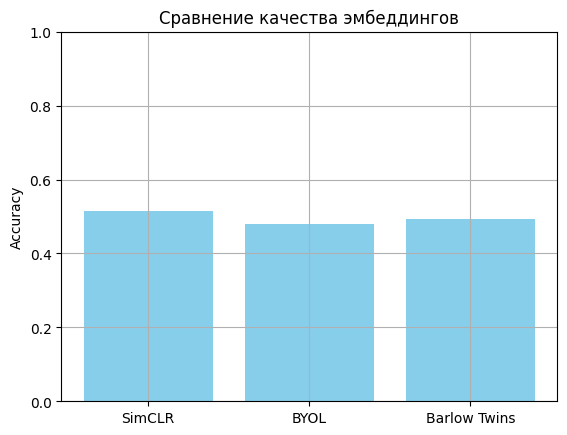

In [22]:
plot_results({"SimCLR": acc_simclr, "BYOL": acc_byol, "Barlow Twins": acc_barlow})

SimCLR показывает лучшую обобщающую способность при обучении логистической регрессии на малом объеме данных.

BYOL чуть слабее, возможно, из-за того, что архитектура требует больше данных или более долгого обучения.

Barlow Twins близко к BYOL, но всё ещё не обошёл SimCLR.